# Tutorial notebook for the UVWindow module

In this notebook, we present how to use the `UVWindow` module, which provides routines to compute exact window functions for a given set of baseline lengths, with relative weights, on a given frequency range.

The structure is as follows:
1. In [Sec. 1](#sec:theory), we present the computation of the exact window functions.
2. In [Sec. 2](#sec:basic), we present basic usage of the `FTBeam` and `UVWindow` modules, implemtenting the above equations.
    * [Initialise a `FTBeam` object](#subsec:ftbeam) from file or direct computation.
    * [Initiliase a `UVWindow` object](#subsec:uvwindow) from scratch
    * [Compte spherical window functions](#subsec:compute_spherical) from the above
    * [Compte cylindrical window functions](#subsec:compute_cylindrical) from the above
3. In [Sec. 3](#sec:uvpspec), we present how to use `UVPSpec` and `UVWindow` jointly to obtain the (weighted) exact window functions from a `UVPSpec` object.
    * [Initialise a `UVWindow` object directly from a `UVPSpec` one](#subsec:uvpspec_init)
    * [Compute the exact window functions of a given `UVPSpec` object](#subsec:uvpspec_compute)
    * [Handling weights](#subsec:uvpspec_weights)
    * [Averaging](#subsec:uvpspec_average), including spherical average
4. In [Sec. 4](#sec:save), we give an example of how to run and save the window functions directly in a h5 file.

## Theoretical background
<a id='sec:theory'></a>

The theoretical background detailling the definition and computation of these window functions can be found in a memo. We only give a short summary here.

There are two classes included in the `uvwindow.py` script.
* `FTBeam`, which is used to compute and access the Fourier transform of the flat-sky approximation of the HERA beam for a given range of frequencies and a given polarisation. It is used internally by `UVWindow`. For now, its value is read from files but a computation from scratch will soon be supported.
* `UVWindow`, which computes the exact window functions given a set of baseline lengths, a pair of polarisations, and a spectral window.

The "Fourier transform of the beam" corresponds to, for $A(\theta,\nu)$ the HERA beam at angular direction $\theta$ and frequency $\nu$, for a given polarisation:
\begin{equation} 
\tilde{A}(\mathbf{q}_\perp,\nu) =  \int \mathrm{d}^2 \theta~ A(\mathbf{\theta,\nu}) ~\mathrm{e}^{-2i\pi \mathbf{\theta} \cdot \mathbf{q}_\perp}
\end{equation}
where the Fourier dual of $\theta$ is
\begin{equation}
\mathbf{q}_\perp \equiv\frac{\nu}{c}\mathbf{b}- \frac{d_c(z)}{2\pi }  \mathbf{k_\perp},
\end{equation}
for $\mathbf{b}$ the baseline length, and $d_c(z)$ the comoving distance to redshift $z(\nu)$.

The cylindrical window fuctions obtained with the module are arrays giving the mapping between instrument space $(b,\tau)$ and cosmological space $(k_\perp,k_\parallel)$. They can be spherically averaged to obtain the spherical window functions.

Then each estimated bandpower $\hat{P}$ at a given $(b,\tau)$ is an integral of the true, cosmological, power spectrum, with the window functions as weights:
\begin{equation}
\hat{P}(b,\tau)=\int \mathrm{d}k_\parallel~\mathrm{d}k_\perp~W(b,\tau,k_\perp,k_\parallel) P(k_\perp,k_\parallel).
\end{equation}

## Setting up the environment

Import necessary modules

In [1]:
from pyuvdata import UVData, UVBeam
from pyuvdata import  utils as uvutils
import hera_pspec as hp
from hera_pspec.data import DATA_PATH
from hera_cal import redcal
from  hera_pspec import utils
from hera_pspec import uvpspec_utils as uvputils

In [2]:
from astropy import units
import numpy as np
from astropy import units
from multiprocessing import Pool
import time, h5py
import matplotlib.pyplot as plt
from matplotlib import colors, cm
%matplotlib inline

In [3]:
from hera_pspec import UVWindow, FTBeam

In [4]:
%load_ext autoreload
%autoreload 2

## Define useful (plotting) functions

In [5]:
def plot_spherical(sph_wf, kbins, step=3):
    """
    Function to conveniently plot window functions 
    as a function of spherical k-bins.
    
    Parameters:
    ----------
    sph_wf: 2D float array
        Array of window functions of dim (kbins.size, kbins.size)
    kbins: 1D float array
        Array of (linear) spherical k-bin centres. 
    """
    # check if dimensions are compatible
    assert sph_wf.shape[0] == np.size(kbins)
    
    # plot figure
    plt.figure()
    for ik in np.arange(0, kbins.size, step):
        plt.plot(kbins, sph_wf[ik, :], color='k')
    plt.xlim(0,1)
    plt.xlabel(r'$k~ [h\mathrm{Mpc}^{-1}]$')
    plt.ylabel(r'$W(k)$')

In [6]:
def compare_spherical(sph_wf1, sph_wf2, kbins1, kbins2=None, step=3, labels=['', '']):
    """
    Function to conveniently plot window functions 
    as a function of spherical k-bins.
    
    Parameters:
    ----------
    sph_wf1: 2D float array
        Array of window functions of dim (kbins.size, kbins.size)
    sph_wf2: 2D float array
        Array of window functions of dim (kbins.size, kbins.size)
        to compare to sph_wf1.
    kbins1: 1D float array
        Array of (linear) spherical k-bin centres corresponding to kbins1.
    kbins2: 1D float array
        Array of (linear) spherical k-bin centres corresponding to kbins2.
        Default is None: kbins is used for both sph_wf.
    step: int
        Interval of spherical window functions plotted 
        (every other step k-bin). Default is 3.
    labels: list of strings
        List of labels to use for sph_wf1 and sph_wf2 in the figure,
        respectively.
    """
    
    if kbins2 is None:
        kbins2 = np.copy(kbins1)
    assert sph_wf1.shape[0] == np.size(kbins1)
    assert sph_wf2.shape[0] == np.size(kbins2)
    assert len(labels) == 2

    plt.figure()
    for ik in np.arange(0, kbins1.size, int(step)):
        plt.plot(kbins1, sph_wf1[ik, :], color='k')
    for ik in np.arange(0, kbins2.size, step):
        plt.plot(kbins2, sph_wf2[ik, :], color='#9e224e', lw=3., alpha=.7)
    plt.plot([], [], color='k', label=labels[0])
    plt.plot([], [], color='#9e224e', lw=3., alpha=.7, label=labels[1])
    plt.xlim(0,1)
    plt.xlabel(r'$k~ [h\mathrm{Mpc}^{-1}]$')
    plt.ylabel(r'$W(k)$')
    plt.legend(loc='upper right', frameon=True)

In [7]:
def plot_cylindrical(wf_array, kperpbins, kparabins, bl_len, tau, avg_nu, mark_centres=False,
                     cosmo=hp.conversions.Cosmo_Conversions(), little_h=True):
    """
    Function to conveniently plot cylindrical window functions 
    as a function of kperp and kpara.
    
    Parameters:
    ----------
    wf_array: 2D float array
        Array of spherical window functions of dim 
        (kperpbins.size, kparabins.size) for a (b, tau) pair.
    kperpbins: 1D float array
        k_\perp grid used to compute the window functions. 
    kparabins: 1D float array
        k_\parallel grid used to compute the window functions. 
    bl_len: float
        Baseline length corresponding to the input wf_array, in meters.
    tau: float
        Delay corresponding to the input wf_array, in seconds.
    avg_nu: float
        Average frequency over the spectral window corresponding to the 
        input wf_array, in Hz.
    mark_centres: boolean, optional
        Set to True if you want to overplot lines showing the bin centre.
    cosmo : hp.conversions.Cosmo_Conversions object, optional
        Cosmology object. Uses the default cosmology object if not
        specified. 
    little_h : boolean, optional
            Whether to have cosmological length units be h^-1 Mpc or Mpc
            Default: True (h^-1 Mpc).
    """
    
    plt.figure()
    im = plt.imshow(wf_array, aspect='auto',
               extent=(kparabins.min(),kparabins.max(),kperpbins.max(),kperpbins.min()))
    plt.ylabel(r'$k_{\perp}$ [h Mpc$^{-1}$]')
    plt.xlabel(r'$k_{\parallel}$ [h Mpc$^{-1}$]')
    plt.title(r'$(b,\tau)=(%.1f ~\mathrm{m},%i ~\mathrm{ns})$' 
              %(bl_len, tau*1e9))
    cbar = plt.colorbar(im, fraction=0.05)
    cbar.set_label(r'$W(k_\perp, k_\parallel)$')
    
    if mark_centres:
        kperp_centre = cosmo.bl_to_kperp(cosmo.f2z(avg_nu), little_h=little_h) * bl_len
        kpara_centre = cosmo.tau_to_kpara(cosmo.f2z(avg_nu), little_h=little_h) * abs(tau)
        plt.axvline(kpara_centre, color='r', lw=.8)
        plt.axhline(kperp_centre, color='r', lw=.8)    

invalid escape sequence '\p'
invalid escape sequence '\p'
invalid escape sequence '\p'


In [8]:
def im_wf_uvp(uvp, ib, it, ip=0, spw=0, mark_centres=False):
    """
    Function to conveniently plot cylindrical window functions 
    as a function of kperp and kpara for a given UVPSpec object.
    
    Parameters:
    ----------
    uvp: UVPSpec object
        UVPSpec object containing at least one polpair, one spw_range.
    ib: int
        index of the baseline-pair you want to plot the window function of,
        must be between 0 and uvp.get_blpair_seps().size-1.
    it: int
        index of the delay you want to plot the window function of,
        must be between 0 and uvp.get_dlys(spw).size-1.
    ip: int
        index of the polarisation-pair you want to plot the window function of,
        must be between 0 and uvp.polpair_array.size-1.
    mark_centres: boolean, optional
        Set to True if you want to overplot lines showing the bin centre.
    """

    kparabins = uvp.window_function_kpara[spw][:, ip]
    kperpbins = uvp.window_function_kperp[spw][:, ip]
    little_h = 'h^-3' in uvp.norm_units
    
    wf_array = uvp.window_function_array[spw][ib, it, :, :, ip]
    bl_len = uvp.get_blpair_seps()[ib]
    tau = uvp.get_dlys(spw)[it]
    spw_range = uvp.get_spw_ranges(spw)[0]
    avg_nu = (spw_range[0]+spw_range[1])/2
    
    plot_cylindrical(wf_array, kperpbins, kparabins, bl_len, tau, avg_nu, mark_centres=mark_centres,
                     cosmo=uvp.cosmo, little_h=little_h)

## Initialise parameters

In [9]:
cosmo = hp.conversions.Cosmo_Conversions()
little_h = True

In [10]:
# Data files to use in tests
folder = '/lustre/aoc/projects/hera/agorce/wf_hera/'
dfile = folder+'HERA_v2.uvh5'
ftfile = folder+'delay_wf/FT_beam_HERA_dipole_yy.hdf5'
base_ftfile = folder+'delay_wf/FT_beam_HERA_dipole'
outfile = 'test.hdf5'

Define the bins used for the spherical window functions. They must be an `astropy` quantity with appropriate units.

In [11]:
# Spherical Binning Parameters
k_start_multiplied = .75 # the center of first spherical k bin in units of Delta k
dk = 0.046
kbins = np.arange(k_start_multiplied * dk, 2.5, dk) # even spacing 
nbinsk = kbins.size
kbin_edges = np.arange(kbins.min()-dk/2,kbins.max()+dk,step=dk)
kbins *= units.h / units.Mpc

Let us extract baseline lengths from a data file. We will then compute window functions for these baselines.

In [12]:
uvd = UVData()
uvd.read_uvh5(dfile, read_data=False)

In [13]:
reds, lens, angs = utils.get_reds(uvd,bl_error_tol=1.0,pick_data_ants=False)

Choose baseline groups used to comput the window functions.

In [14]:
bl_lens = lens[::10]
print(bl_lens)

[np.float64(14.605287651600797), np.float64(38.6513756041072), np.float64(50.61035358581802), np.float64(63.67930178890329), np.float64(66.94147018901626), np.float64(77.29908245579671), np.float64(87.64817185719119), np.float64(91.2288483918722), np.float64(95.79107914972985), np.float64(102.25757190969506), np.float64(110.29239537179313), np.float64(115.95800845253738), np.float64(124.8193645853515)]


## 1. Compute the window functions: Basic usage
<a id='sec:basic'></a>

The derivation of the window function relies on Fourier transforms performed on the beam of the instrument. The spatial Fourier transforms of the flat-sky-approximated beam have been pre-computed and an example file (called `ftfile` below) is available in `hera_pspec/data/`. This file corresponds to the beam for the `xx` polarisation and a reduced spectral window to save disk space but is not used here to provide realistic window functions.

In [15]:
spw_range = (176, 340)
pol = 'yy'

### a. Initialise  `FTBeam` object
<a id='subsec:ftbeam'></a>

The `FTBeam` object takes several different inputs:
* A 3D array `data` containing the real part of the Fourier transform of the beam in the sky plane (flat-sky approximation), for a set of frequencies given by `freq_array`.
* A polarisation channel (e.g., 'xx', can also be a polarisation integer).
* The spectral window `freq_array` corresponding to `data`, given as a list (or 1d array) of frequencies in Hz.
* The parameter `mapsize`, corresponding to the size of the flat map the beam was projected onto (in deg)
* The orientation in cardinal direction east or north of X dipole, given in `x_orientation`.

The inputs (esp. `data` and `freq_array`) should be chosen with respect to the window functions that the user want to compute, as the `FTBeam` object will be fed directly to the `UVWindow` object to initialise it.

It is usually easier to initialise the `FTBeam` object through the class methods `from_beam` and `from_file` as illustrated below.

#### 1.1 Initialise from file

The `FTBeam.from_file` method reads a h5py file containing the real part of the Fourier transform of the beam in the sky plane to initialise a `FTBeam` object with the appropriate properties. It must be fed:
* `ftfile`, the path to the file constraining to the Fourier transform of the beam on the sky plane, including the polarisation (e.g., path/to/file/ft_beam_HERA_dipole_pI.hdf5)
* `spw_range` as a tuple of the indices of the minimum and maximum frequencies used to compute the FT above. The indices are tken over the total instrument bandwidth. If `None`, the whole instrument bandwidth is considered.
* The orientation in cardinal direction east or north of X dipole, given in `x_orientation`.

In [17]:
ftbeam = FTBeam.from_file(ftfile=ftfile, spw_range=spw_range, x_orientation=uvd.telescope.x_orientation)

#### 1.2 Initialise from beam

The `FTBeam.from_beam` function is not implemented yet, and will raise a `NotImplementedError` if you try to call it. In the future, it will directly derive the Fourier transform of the beam in the sky plane, given path to file containing beam simulations for a given polarisation.

### b. Initialise  UVWindow object
<a id='subsec:uvwindow'></a>

Most of the `UVWindow` object's attributes are initialised through the `FTBeam` object given as input (e.g., `pols`, `freq_array1`, ...). The `ftbeam_obj` can be either an individual object (then the window functions are computed for the auto-correlation of the polarisation of the object) or a list/tuple/array of two `FTbeam` objects that will be cross-correlated in the computation (see Memo).

To initialise the `UVWindow` object, you can give additional (optional) inputs related to the computation of the window functions:
* A `taper` used to smooth the data along the spectral window. Ex: 'blackman-harris'.
* A `conversions.Cosmo_Conversions` object for cosmological calculations.
* The boolean `little_h` which indicates if $k$ units include $h$ or not.

In [18]:
uvw = UVWindow(ftbeam_obj = ftbeam,
               taper = 'blackman-harris',
               cosmo=cosmo,
               little_h=little_h,
               verbose=True)

In [19]:
np.all(uvw.freq_array==ftbeam.freq_array)

np.True_

In [20]:
uvw.ftbeam_obj_pol[0].pol, uvw.pols[0]

('yy', 'yy')

Within the `UVWindow` object, the input `FTBeam` objects are saved in a list (one element for each polarisation):

In [21]:
uvw.ftbeam_obj_pol

The `UVWindow` object has useful attributes, such as the average frequency (in Hz) and redshift over the spectral window considered:

In [22]:
uvw.avg_z, uvw.avg_nu

(np.float64(10.349945290862271), np.float64(125146484.375))

If `little_h=True`, then the attribute `uvw.kunits` includes $h$:

In [23]:
uvw.kunits

Unit("h / Mpc")

### c. Compute spherical window functions
<a id='subsec:compute_spherical'></a>

We use the `get_spherical_wf` to directly access the spherically-averaged window functions, for a given set of baseline lengths. The function uses different inputs:
* The set of spherical $k$-bins to use, as an `astropy` quantity with units.
* A list of baseline lengths `bl_lens`, with, as an option, a list of associated weights (`bl_weights`)
* Lists of $k_\perp$ and $k_\parallel$ values, which will be used to grid the cylindrical window functions (see below)
* An option to return spherical $k$-bin values weighted by the number of $(b, \tau)$ contributing to the bin (`return_weighted_k=True`)

In [24]:
t0 = time.time()
sph_wf = uvw.get_spherical_wf(kbins,
                              bl_lens = bl_lens, bl_weights=None,
                              kperp_bins=None, kpara_bins=None,
                              return_weighted_k=False,
                              verbose = True)
t1 = time.time()
print('Computed wf in %.1f mins' %((t1-t0)/60.))

Max spherical k probed is not included in bins.


Computing for blg 13 of 13... 
Computed wf in 5.5 mins


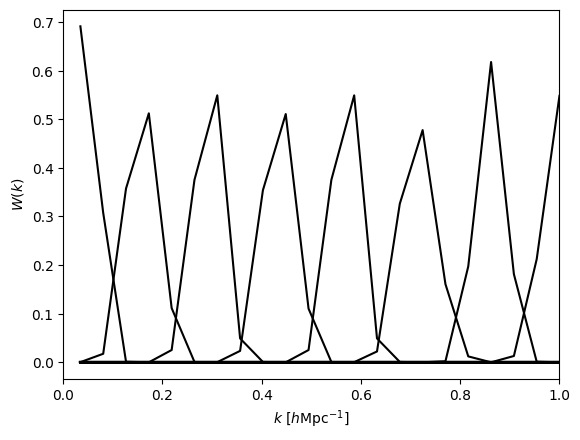

In [25]:
plot_spherical(sph_wf, kbins)

### d. Compute cylindrical window functions
<a id='subsec:compute_cylindrical'></a>

It is also possible to compute the cylindrical window functions for a given baseline length:

In [26]:
# choose baseline
ib = 12
# choose delay
it = 3

In [27]:
kperp, kpara, cyl_wf = uvw.get_cylindrical_wf(bl_lens[ib], kperp_bins=None, kpara_bins=None, 
                                              return_bins='unweighted')

The $k_\perp$ and $k_\parallel$ bins used as a grid to compute these functions are returned simultaneously with the `return_bins` option. If the option is `return_bins='weighted'`, then we retrieve the $k_\perp$ and $k_\parallel$ bins weighted by the number of modes used to compute each value.

The resulting array is $W(b,\tau,k_\perp,k_\parallel)$ and has shape (Ndlys, Nkperp, Nkpara).

In [28]:
cyl_wf.shape

(164, 38, 90)

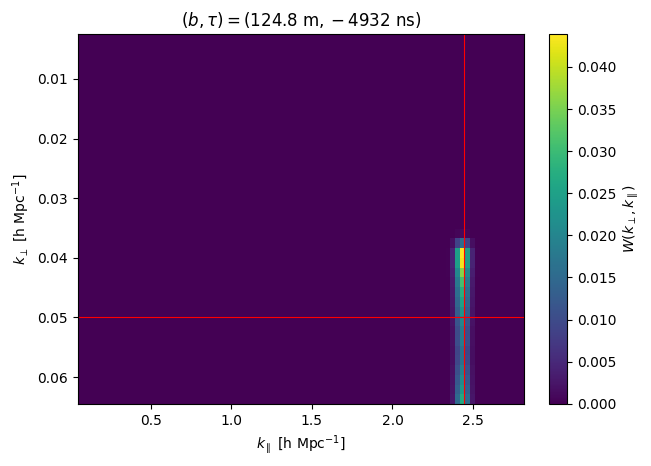

In [29]:
plot_cylindrical(cyl_wf[it,:,:], kperp, kpara, bl_lens[ib], uvw.dly_array[it],
                 uvw.avg_nu, mark_centres=True, cosmo=uvw.cosmo, little_h=uvw.little_h)

The cylindrical window functions can then be averaged to obtain the spherical ones:

In [30]:
# compute the gride of $k$ magnitudes covered by the array
ktot = np.sqrt(kperp[:, None]**2 + kpara**2)
# and average
sph_wf2, _ = uvw.cylindrical_to_spherical(cyl_wf, kbins, ktot, bl_lens[ib])

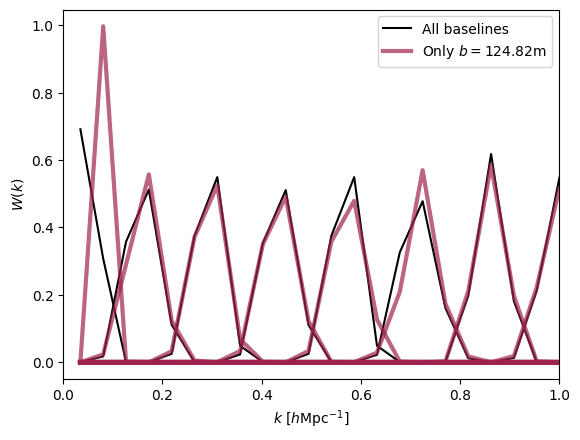

In [31]:
compare_spherical(sph_wf, sph_wf2, kbins,
                  labels=['All baselines', r'Only $b=%.2f$m' %(bl_lens[ib])])

The result is naturally different from the one using all the baselines.

## 3. UVWindow & UVPSpec
<a id='sec:uvpspec'></a>

Let's first obtain a `UVPSPec` object which we be used for futher examples.

Initialise UVData object

In [32]:
uvd = UVData()
uvd.read_uvh5(dfile)

Load beam

In [35]:
# List of beamfile to load. This is a healpix map.
import os
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
# intantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=None)
# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol=pol)
# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, :, None]

Create data set to cross-correlate

In [36]:
# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd, uvd], wgts=[None, None], beam=uvb)

Choose parameters to compute the power spectrum:

In [37]:
baselines = [uvd.baseline_to_antnums(bl) for bl in np.unique(uvd.baseline_array)]
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines,
                                                             exclude_permutations=False,
                                                             exclude_auto_bls=True)

In [38]:
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=spw_range, 
               taper='blackman-harris',verbose=False)

Casting complex values to real discards the imaginary part


### a. Initialise `UVWindow` object from `UVPSpec` object
<a id='subsec:uvpspec_init'></a>

Initialise `UVWindow` object from `uvp` -- the `FTBeam` object required to initialise `UVWindow` will be internally computed.

In [39]:
uvw_ps = UVWindow.from_uvpspec(uvp, ftfile=base_ftfile, ipol=0, spw=0,
                               x_orientation=uvd.x_orientation, verbose=True)

AttributeError: 'UVData' object has no attribute 'x_orientation'

The properties of the `UVPSpec` object are parsed to the `UVWindow` object.

In [ ]:
uvp.taper,uvw_ps.taper

In [ ]:
uvp.polpair_array[0], uvw_ps.pols

Then, we can use the module functions as before:

In [ ]:
sph_wf3 = uvw_ps.get_spherical_wf(kbins,
                                  kperp_bins=None,
                                  kpara_bins=None,
                                  bl_lens = bl_lens,
                                  verbose = True)

In [ ]:
plot_spherical(sph_wf3, kbins)

### b. Extract exact window functions from `UVPSpec` object
<a id='sec:uvpspec_compute'></a>

Set `exact_windows=True` when calling `ds.pspec` to directly obtain and save as attributes the exact window functions.

In [ ]:
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=spw_range, 
               taper='blackman-harris', verbose=False, exact_windows=True, ftbeam_file=base_ftfile)
print(uvp.exact_windows)

You can also use the `get_exact_window_functions` method in `UVPSpec` on a pre-existing object:

In [40]:
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=spw_range, 
               taper='blackman-harris', verbose=False, exact_windows=False)
print(uvp.exact_windows)

False


In [43]:
uvp.get_exact_window_functions(
    ftbeam=base_ftfile, inplace=True,
    x_orientation=uvd.telescope.x_orientation
)
print(uvp.exact_windows)

True


The exact window functions are assigned as attributes of the UVPSpec object, along with the $k_\perp$ and $k_\parallel$ grids used to compute them. The attribute `uvp.exact_windows` is set to True.

In [ ]:
uvp.N

In [45]:
spw = 0

print(uvp.window_function_array[spw].shape)
print(uvp.Nbltpairs,
      uvp.Ndlys,
      uvp.window_function_kperp[spw].size,
      uvp.window_function_kpara[spw].size,
      uvp.Npols)

(120, 164, 22, 90, 1)
120 164 22 90 1


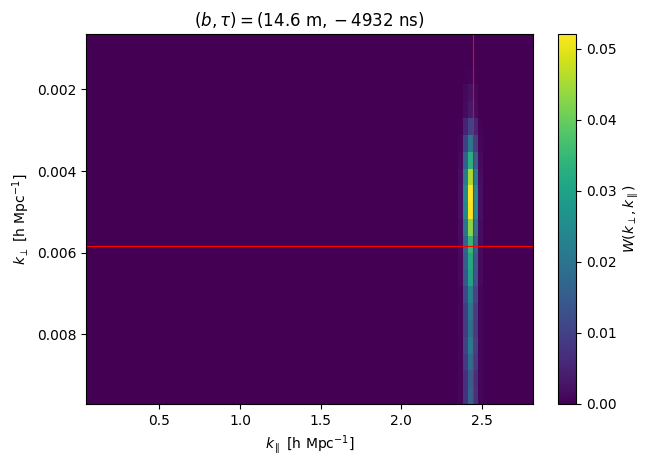

In [46]:
im_wf_uvp(uvp, ib=12, it=3, ip=0, spw=0, mark_centres=True)

The result of `uvp.get_red_blpairs()` is used to group baseline-pairs by redundancy groups.

Once `uvp.exact_windows=True`, you can call the window functions with `uvp.get_window_function`, as for the initial computation:

In [47]:
spw = 0 
blpair = uvp.blpair_array[2]
polpair = uvp.polpair_array[0]

key = (spw, blpair, polpair)
W = uvp.get_window_function(key)
print(W.shape)

(60, 164, 22, 90)


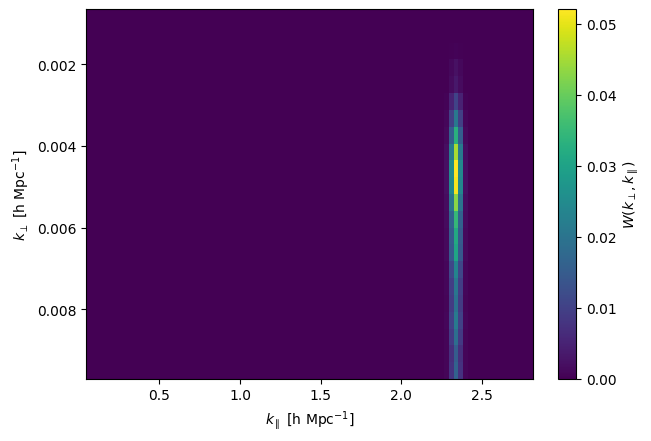

In [48]:
ip = 0 # polarisation channel
kperp = uvp.window_function_kperp[spw][:, ip]
kpara = uvp.window_function_kpara[spw][:, ip]
ib = 4
it = 6
plt.figure()
im = plt.imshow(W[ib, it, :, :], aspect='auto',
           extent=(kpara.min(), kpara.max(), kperp.max(), kperp.min()))
plt.ylabel(r'$k_{\perp}$ [h Mpc$^{-1}$]')
plt.xlabel(r'$k_{\parallel}$ [h Mpc$^{-1}$]')
cbar = plt.colorbar(im, fraction=0.05)
cbar.set_label(r'$W(k_\perp, k_\parallel)$')

The `inplace` option allows you to choose if you want to save the exact window functions and the corresponding $k_\perp$ and $k_\parallel$ bins as attributes or if you just want to output the results. If `inplace=False`, you can choose the spectral window over which to compute the window functions with the `spw_array` argument.

In [51]:
uvp2 = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=spw_range,
               taper='blackman-harris', verbose=False)
uvw_ps = UVWindow.from_uvpspec(
    uvp2, ftbeam=base_ftfile, ipol=0, spw=0,
    x_orientation=uvd.telescope.x_orientation, verbose=False
)

In [52]:
spw = 0

kperp_bins, kpara_bins, cyl_wf = uvp2.get_exact_window_functions(
    ftbeam=base_ftfile, inplace=False,
    x_orientation=uvd.telescope.x_orientation, spw_array=spw
)
print(cyl_wf[spw].shape, kperp_bins[spw].shape, kpara_bins[spw].shape)

(120, 164, 22, 90, 1) (22, 1) (90, 1)


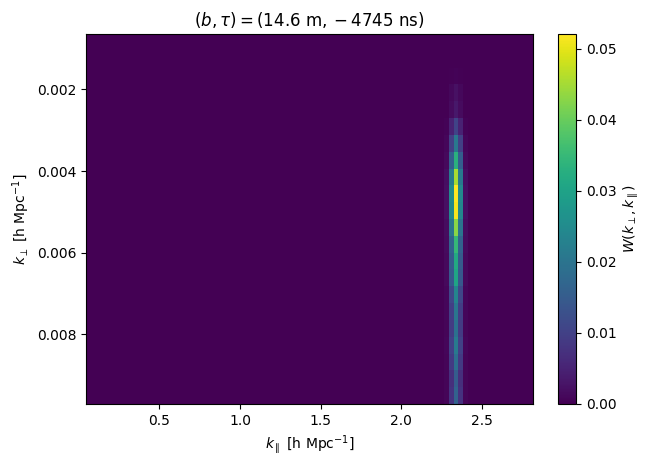

In [53]:
ib = 4
it = 6
plot_cylindrical(cyl_wf[spw][ib, it, : ,:, 0], kperp_bins[spw], kpara_bins[spw], uvp2.get_red_blpairs()[1][0],
                 uvw_ps.dly_array[it], uvw_ps.avg_nu, cosmo=uvp2.cosmo, little_h=uvw_ps.little_h)

<a id='subsec:uvpspec_weights'></a>
### c. Applying weights

At this stage, the window function of each baseline-delay pair $(b, \tau)$ is normalised to one according to
$\sum_{(k_\perp, k_\parallel)} W_{(b, \tau)}(k_\perp, k_\parallel) = 1$, and no weights are applied:

In [54]:
np.sum(W[ib, it, :, :])

np.float64(1.0)

To apply weights, use `hp.grouping.average_spectra` with `blpair_groups=None` and `time_avg=False`. See below an example for a simulated noise spectrum as weights.

In [55]:
for key in uvp.get_all_keys():
    spw = key[0]
    blp = uvp.antnums_to_blpair(key[1])
    polpair = uvputils.polpair_tuple2int(key[2])
    P_N = uvp.generate_noise_spectra(spw=0, polpair=uvp.polpair_array[0], Tsys=300.0, 
                                     form='Pk',little_h=little_h)[blp]
    uvp.set_stats('noise', key, P_N)

In [56]:
uvp_noise_weighted = uvp.average_spectra(blpair_groups=uvp.get_red_blpairs()[0], time_avg=False,
                                         error_weights='noise', inplace=False)

0.05206607959712048
3.8485245968125544e-22


Text(0.5, 0.98, '$(b,\\tau)=(14.6 ~\\mathrm{m}, 4745 ~\\mathrm{ns})$')

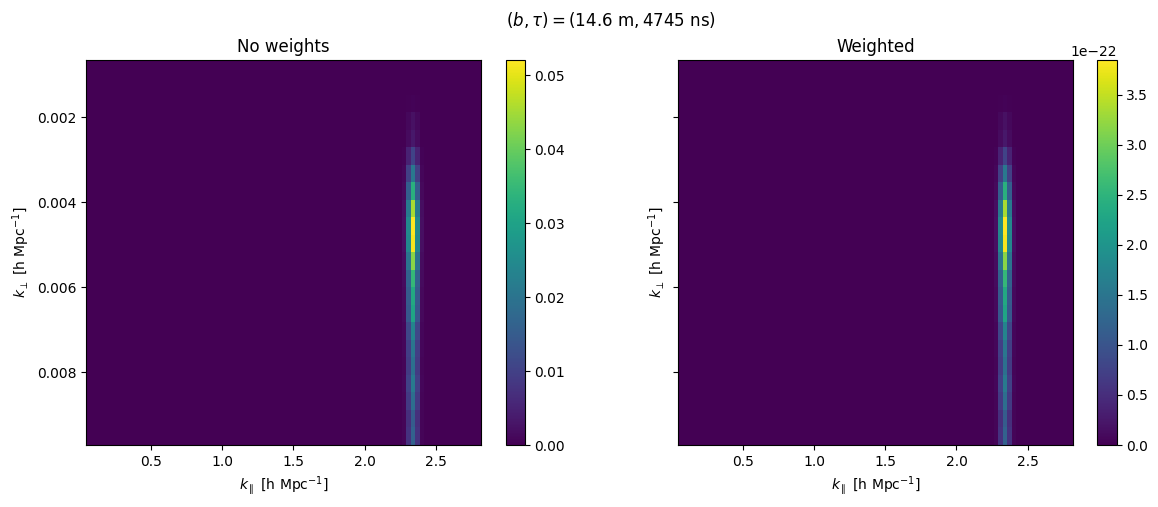

In [57]:
spw = 0
ipol = 0

kperp = uvp.window_function_kperp[spw][:, ipol]
kpara = uvp.window_function_kpara[spw][:, ipol]

it = 6
iblts = -1

W_array = [uvp.window_function_array[spw][iblts, it, :, :, 0],
           uvp_noise_weighted.window_function_array[spw][iblts, it, :, :, 0]]
titles = ['No weights', 'Weighted']

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)
for u, ax in enumerate(axes):
    print(W_array[u].max())
    im = ax.imshow(W_array[u],
                   extent=(kpara.min(),kpara.max(),kperp.max(),kperp.min()),aspect='auto')
    ax.set_ylabel(r'$k_{\perp}$ [h Mpc$^{-1}$]')
    ax.set_xlabel(r'$k_{\parallel}$ [h Mpc$^{-1}$]')
    ax.set_title(titles[u])
    plt.colorbar(im, ax=ax)
plt.suptitle(r'$(b,\tau)=(%.1f ~\mathrm{m}, %i ~\mathrm{ns})$' 
          %(uvp.get_blpair_seps()[iblts],abs(uvp.get_dlys(spw)[it])*1e9))

Note that, in case the `UVPSpec` object has been previously averaged, the function does *not* check if the baselines called in `blpair_lens` and `blpair_groups` are indeed included in the `UVPSpec` data.

### 3. Averaging
<a id='subsec:uvpspec_averaging'></a>

In [58]:
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=spw_range, 
               taper='blackman-harris',verbose=False)

In [59]:
uvp.get_exact_window_functions(
    ftbeam=base_ftfile, inplace=True,
    x_orientation=uvd.telescope.x_orientation
)

Once the exact window functions have been computed, it is possible to apply error weights, or to average them by time or redundancy with the `grouping.average_spectra` method. If `uvp.exact_windows = False`, the ordinary computations will be performed.

In [60]:
print(uvp.window_function_array[0].shape)
hp.grouping.average_spectra(uvp, time_avg=True, inplace=True)
print(uvp.window_function_array[0].shape)

(120, 164, 22, 90, 1)
(2, 164, 22, 90, 1)


Note that the time-average does not change anything to the window functions and only changes the shape of the resulting array.

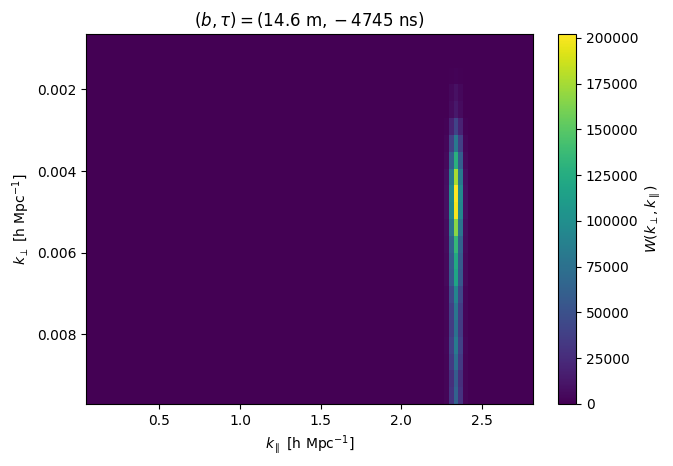

In [61]:
ib = 0
it = 6
ip = 0 #polarisation channel
spw = 0
im_wf_uvp(uvp, ib, it, ip, spw, mark_centres=False)

#### Spherical average

All the above options return the cylindrical window functions, which you can later spherically average with the method `grouping.spherical_wf_from_uvp` as detailled above. However, you can directly access the spherical window functions if you spherically average your `UVPSpec` object.

In [62]:
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=spw_range, 
               taper='blackman-harris',verbose=False)

In [65]:
uvp.get_exact_window_functions(
    ftbeam=base_ftfile, inplace=True,
    x_orientation=uvd.telescope.x_orientation
)

In [66]:
sph_uvp = hp.grouping.spherical_average(uvp, kbins.value, bin_widths=np.diff(kbins.value).mean(),
                                        blpair_groups=uvp.get_red_blpairs()[0], time_avg=True)

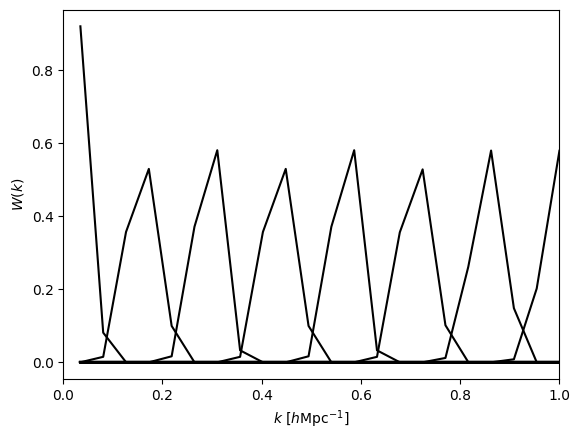

In [67]:
plot_spherical(sph_uvp.window_function_array[spw][0, :, :, 0], kbins.value)

<a id='sec:save'></a>
### Compute cylindrical window functions and save

In [68]:
uvw = UVWindow(ftbeam_obj = ftbeam,
               taper = 'blackman-harris',
               cosmo=cosmo,
               little_h=little_h,
               verbose=True)

In [69]:
uvw.run_and_write(filepath=outfile,
                  bl_lens = bl_lens[:2],
                  kperp_bins=None,
                  kpara_bins=None,
                  clobber=True)
print(os.path.isfile(outfile))

True


In [70]:
print(os.path.isfile(outfile))
os.remove(outfile)

True
